# Test model Using GLove 

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Concatenate, Dropout, AdditiveAttention, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import pickle
from tensorflow.keras.mixed_precision import set_global_policy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
set_global_policy('mixed_float16')

# Load dataset
file_path = '/kaggle/input/medquad/medquad.csv'
data = pd.read_csv(file_path)


print("Data Sample")
print(data.head())

#Null value
print("Null Value Data")
print(data.isnull().sum())

duplicates = data.duplicated(['question'], keep=False).sum()
print(f"Total duplicates in 'question' column: {duplicates}")

# Check for duplicate rows

duplicates = data.duplicated()
print(f"Number of duplicate rows: {duplicates.sum()}")

# Remove duplicate rows
data = data.drop_duplicates()

# Reset the index after removing duplicates
data.reset_index(drop=True, inplace=True)

#Table Info
print("Table Info")
print(data.info())

# Apply the function
data = data.drop_duplicates(subset='question', keep='first').reset_index(drop=True)
data = data.drop_duplicates(subset='answer', keep='first').reset_index(drop=True)

#Drop rows with null values
data.dropna(inplace=True)

#Checking again 
print("Null Value Data")
print(data.isnull().sum())


print(data.info())

Data Sample
                                 question  \
0                What is (are) Glaucoma ?   
1                  What causes Glaucoma ?   
2     What are the symptoms of Glaucoma ?   
3  What are the treatments for Glaucoma ?   
4                What is (are) Glaucoma ?   

                                              answer           source  \
0  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   
1  Nearly 2.7 million people have glaucoma, a lea...  NIHSeniorHealth   
2  Symptoms of Glaucoma  Glaucoma can develop in ...  NIHSeniorHealth   
3  Although open-angle glaucoma cannot be cured, ...  NIHSeniorHealth   
4  Glaucoma is a group of diseases that can damag...  NIHSeniorHealth   

  focus_area  
0   Glaucoma  
1   Glaucoma  
2   Glaucoma  
3   Glaucoma  
4   Glaucoma  
Null Value Data
question       0
answer         5
source         0
focus_area    14
dtype: int64
Total duplicates in 'question' column: 2319
Number of duplicate rows: 48
Table Info
<class 

Epoch 1/20
723/723 ━━━━━━━━━━━━━━━━━━━━ 306s 415ms/step - accuracy: 0.1806 - loss: 6.3588 - val_accuracy: 0.4237 - val_loss: 4.1297 - learning_rate: 0.0010
Epoch 2/20
723/723 ━━━━━━━━━━━━━━━━━━━━ 301s 416ms/step - accuracy: 0.4334 - loss: 4.0000 - val_accuracy: 0.4699 - val_loss: 3.6322 - learning_rate: 0.0010
Epoch 3/20
723/723 ━━━━━━━━━━━━━━━━━━━━ 303s 419ms/step - accuracy: 0.4745 - loss: 3.4489 - val_accuracy: 0.4933 - val_loss: 3.3879 - learning_rate: 0.0010
Epoch 4/20
723/723 ━━━━━━━━━━━━━━━━━━━━ 302s 418ms/step - accuracy: 0.4963 - loss: 3.0793 - val_accuracy: 0.5068 - val_loss: 3.2501 - learning_rate: 0.0010
Epoch 5/20
723/723 ━━━━━━━━━━━━━━━━━━━━ 302s 417ms/step - accuracy: 0.5194 - loss: 2.7548 - val_accuracy: 0.5144 - val_loss: 3.1737 - learning_rate: 0.0010
Epoch 6/20
723/723 ━━━━━━━━━━━━━━━━━━━━ 302s 418ms/step - accuracy: 0.5316 - loss: 2.5358 - val_accuracy: 0.5205 - val_loss: 3.1352 - learning_rate: 0.0010
Epoch 7/20
723/723 ━━━━━━━━━━━━━━━━━━━━ 302s 418ms/step - accura

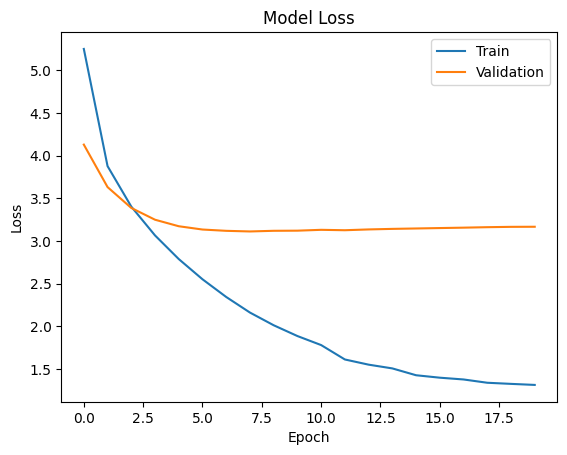

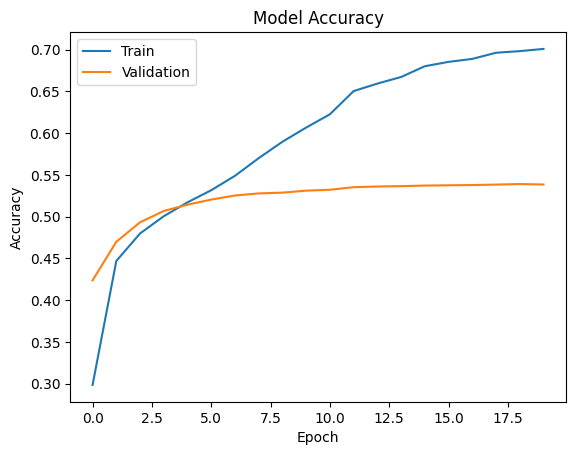

AttributeError: 'Functional' object has no attribute 'state_dict'

In [ ]:



# Preprocessing
data = data.dropna(subset=['answer']).reset_index(drop=True)
data['answer'] = data['answer'].apply(lambda x: f'<start> {x} <end>')

# Split dataset
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_questions = train_data['question'].tolist()
train_answers = train_data['answer'].tolist()
test_questions = test_data['question'].tolist()
test_answers = test_data['answer'].tolist()

# Tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
tokenizer.fit_on_texts(train_questions + train_answers)
vocab_size = len(tokenizer.word_index) + 1
max_length = 40  

# Tokenize and pad sequences
train_questions_seq = tf.keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(train_questions), maxlen=max_length, padding='post'
)
train_answers_seq = tf.keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(train_answers), maxlen=max_length, padding='post'
)
test_questions_seq = tf.keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(test_questions), maxlen=max_length, padding='post'
)
test_answers_seq = tf.keras.preprocessing.sequence.pad_sequences(
    tokenizer.texts_to_sequences(test_answers), maxlen=max_length, padding='post'
)

# Shift decoder inputs and outputs
train_decoder_input = train_answers_seq[:, :-1]
train_decoder_output = train_answers_seq[:, 1:]
test_decoder_input = test_answers_seq[:, :-1]
test_decoder_output = test_answers_seq[:, 1:]

# Pad shifted sequences
train_decoder_input = tf.keras.preprocessing.sequence.pad_sequences(
    train_decoder_input, maxlen=max_length, padding='post'
)
train_decoder_output = tf.keras.preprocessing.sequence.pad_sequences(
    train_decoder_output, maxlen=max_length, padding='post'
)
test_decoder_input = tf.keras.preprocessing.sequence.pad_sequences(
    test_decoder_input, maxlen=max_length, padding='post'
)
test_decoder_output = tf.keras.preprocessing.sequence.pad_sequences(
    test_decoder_output, maxlen=max_length, padding='post'
)

# Load GloVe embeddings
embedding_index = {}
with open('/kaggle/input/gloveb/glove.6B.300d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefficients = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefficients

# Create embedding matrix
embedding_dim = 100  
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector[:embedding_dim]


# Build model
units = 256  
dropout_rate = 0.3

# Encoder
encoder_inputs = Input(shape=(max_length,), name="encoder_inputs")
encoder_embedding = Embedding(
    vocab_size, embedding_dim, weights=[embedding_matrix], trainable=True
)(encoder_inputs)
encoder_lstm = Bidirectional(
    LSTM(units, return_sequences=True, return_state=True, dropout=dropout_rate)
)
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_embedding)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

# Decoder
decoder_inputs = Input(shape=(max_length,), name="decoder_inputs")
decoder_embedding = Embedding(
    vocab_size, embedding_dim, weights=[embedding_matrix], trainable=True
)(decoder_inputs)
decoder_lstm = LSTM(units * 2, return_sequences=True, return_state=True, dropout=dropout_rate)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])

# Attention Mechanism
attention_weights = tf.keras.layers.Attention()([decoder_outputs, encoder_outputs])
context_vector = Concatenate(axis=-1)([attention_weights, decoder_outputs])
context_vector = Dropout(dropout_rate)(context_vector)

# Dense output
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(context_vector)

# Compile model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
checkpoint_filepath = '/kaggle/working/best_model.h5.keras'
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5),
    ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', save_best_only=True)
]

# Train model
batch_size = 16
epochs = 20
history = model.fit(
    [train_questions_seq, train_decoder_input],
    train_decoder_output,
    validation_data=([test_questions_seq, test_decoder_input], test_decoder_output),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks
)

# Save model and tokenizer
model.save('/kaggle/working/final_glove_model.h5.keras')
with open('/kaggle/working/tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

print('success')



# Training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

model_path = "/kaggle/working/glove_chatbot_model.h5.keras"
torch.save(model.state_dict(), model_path)

print("Model state dictionary saved successfully.")

In [ ]:
from tensorflow.keras.models import load_model

# Load the best model from checkpoint
checkpoint_path = '/kaggle/working/best_model.h5.keras'
model = load_model(checkpoint_path)

# Save the model properly
model.save('/kaggle/working/final_model_glove.h5.keras') 
with open('/kaggle/working/tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)
print("Model successfully saved as 'final_model.h5'")


# Beam Search

In [ ]:
import numpy as np
import tensorflow as tf

def predict_response_beam_search(input_text, beam_width=3):
    # Preprocessing input
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_seq = tf.keras.preprocessing.sequence.pad_sequences(input_seq, maxlen=max_length, padding='post')

    # Initial decoder input (<start>)
    start_token = tokenizer.word_index['<start>']
    end_token = tokenizer.word_index['<end>']
    initial_decoder_input = np.zeros((1, max_length))
    initial_decoder_input[0, 0] = start_token

    # Beam search variables
    beams = [(initial_decoder_input, [], 0)] 
    
    for _ in range(max_length):
        new_beams = []
        for decoder_input, response, log_prob in beams:
            predictions = model.predict([input_seq, decoder_input], verbose=0)
            next_token_probs = predictions[0, len(response), :]
            
            # Get top `beam_width` tokens and their probabilities
            top_tokens = np.argsort(next_token_probs)[-beam_width:]
            for token in top_tokens:
                token_prob = next_token_probs[token]
                new_response = response + [token]
                new_decoder_input = decoder_input.copy()
                
                # Prevent writing beyond max_length
                if len(response) + 1 < max_length:  
                    new_decoder_input[0, len(response) + 1] = token
                
                new_log_prob = log_prob + np.log(token_prob + 1e-10) 
                
                new_beams.append((new_decoder_input, new_response, new_log_prob))
        
        
        beams = sorted(new_beams, key=lambda x: x[2], reverse=True)[:beam_width]

        # Stop if all beams end with <end> token
        if all(response[-1] == end_token for _, response, _ in beams):
            break

    # Choose the best beam
    best_beam = max(beams, key=lambda x: x[2])
    best_response = best_beam[1]

    # Convert token IDs to words
    response_words = [tokenizer.index_word.get(token, '') for token in best_response if token != end_token]
    return ' '.join(response_words)


user_input = "What is diabetes?"
print("Bot:", predict_response_beam_search(user_input, beam_width=5))


Bot: coccygodynia is a rare condition that affects the peripheral nervous system, which connects the brain and spinal cord to the brain and spinal cord tumors.              
